# Create dummy data for operation check

In [1]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import os
from pathlib import Path
from typing import List
pwd = Path(os.getcwd())

import pytz
import random
import sys
sys.path.append(str(pwd.parent))
sys.path.append(str(pwd.parent / "config"))

import warnings
warnings.simplefilter("ignore")

import networkx as nx
import numpy as np
from osmread import parse_file, Node, Way
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

from config import Config
from util import haversine
import matplotlib.pyplot as plt
import matplotlib as mpl

config = Config.load()

In [2]:
@dataclass
class Node:
    node_id: int
    node_index: int
    longitude: float
    latitude: float


class Grid:
    def __init__(
        self,
        idx,
        west_bound,
        east_bound,
        south_bound,
        north_bound,
        center_longitude,
        center_latitude,
    ):
        self.idx = idx
        self.__west_bound = west_bound
        self.__east_bound = east_bound
        self.__south_bound = south_bound
        self.__north_bound = north_bound
        self.__center_longitude = center_longitude
        self.__center_latitude = center_latitude
        self.__centroid = None
        self.__nodes = []
        self.__total_cost = 0.0
        self.done_flag = False

    @property
    def west_bound(self):
        return self.__west_bound

    @property
    def east_bound(self):
        return self.__east_bound

    @property
    def south_bound(self):
        return self.__south_bound

    @property
    def north_bound(self):
        return self.__north_bound

    @property
    def center_longitude(self):
        return self.__center_longitude

    @property
    def center_latitude(self):
        return self.__center_latitude

    @property
    def total_cost(self):
        return self.__total_cost
    
    def add_cost(self, cost: float) -> None:
        self.__total_cost += cost

    @property
    def centroid(self) -> Node:
        return self.__centroid

    def set_centroid(self, centroid: Node) -> None:
        self.__centroid = centroid
        self.__nodes.append(centroid)

    def get_nodes(self):
        return [node for node in self.__nodes]
        
    def add_node(self, node: Node) -> None:
        self.__nodes.append(node)

class GridManager:
    def __init__(self):
        self.__grid_list = []

    def add_grid(self, grid):
        self.__grid_list.append(grid)

    def get_grids(self):
        return [grid for grid in self.__grid_list]
        
    def get_minimun_cost_grid(self):
        min_cost = np.inf
        min_grid = None
        for grid in list(filter(lambda x: not x.done_flag, self.__grid_list)):
            if grid.total_cost < min_cost:
                min_grid = grid
            min_cost = min(min_cost, grid.total_cost)
        return min_grid

    def __len__(self):
        return len(self.__grid_list)
    

class CostDB:
    def __init__(self, cost_csv_path, node_csv_path) -> None:
        node_id_list_df = pd.read_csv(node_csv_path)
        self.node_id_map = {
            node_id: node_index for node_index, node_id in zip(
                node_id_list_df["NodeIndex"].values,
                node_id_list_df["NodeID"].values
            )
        }
        self.cost_matrix = pd.read_csv(cost_csv_path, header=None).values

    def calc_cost(self, start_node_id, end_node_id) -> float:
        start_idx = self.node_id_map[start_node_id]
        end_idx = self.node_id_map[end_node_id]
        return self.cost_matrix[start_idx][end_idx]
        

cost_db = CostDB(cost_csv_path="../data/AccurateMap.csv", node_csv_path="../data/Node.csv")

In [3]:
df = pd.read_csv("../data/NodeConnection.csv")
node_info_df = df[["NodeID", "Longitude", "Latitude"]].drop_duplicates()
node_info = {
    node_id: {
        "node_index": node_index,
        "longitude": longitude,
        "latitude": lattitude,
    } for node_index, (node_id, longitude, lattitude) in enumerate(
        zip(node_info_df["NodeID"].values, node_info_df["Longitude"].values, node_info_df["Latitude"].values))
}

In [4]:
__average_longitude = (config.LOCAL_REGION_BOUND.east_bound - config.LOCAL_REGION_BOUND.west_bound) / 2
__average_latitude = (config.LOCAL_REGION_BOUND.north_bound - config.LOCAL_REGION_BOUND.south_bound) / 2

num_grid_width = int(
    haversine(
        config.LOCAL_REGION_BOUND.west_bound,
        __average_latitude,
        config.LOCAL_REGION_BOUND.east_bound,
        __average_latitude,
    )
    / config.SIDE_LENGTH_KIRO_METER
    + 1
)
num_grid_height = int(
    haversine(
        __average_longitude,
        config.LOCAL_REGION_BOUND.south_bound,
        __average_longitude,
        config.LOCAL_REGION_BOUND.north_bound,
    )
    / config.SIDE_LENGTH_KIRO_METER
    + 1
)

In [5]:
total_width = config.LOCAL_REGION_BOUND.east_bound - config.LOCAL_REGION_BOUND.west_bound
total_height = config.LOCAL_REGION_BOUND.north_bound - config.LOCAL_REGION_BOUND.south_bound
interval_width = total_width / num_grid_width
interval_height = total_height / num_grid_height

In [6]:
# create grid
grid_manager = GridManager()
for i in range(num_grid_height):
    smaller_y = config.LOCAL_REGION_BOUND.south_bound + interval_height*i
    larger_y = config.LOCAL_REGION_BOUND.south_bound + interval_height*(i+1)
    for j in range(num_grid_width):    
        smaller_x = config.LOCAL_REGION_BOUND.west_bound + interval_width*j
        larger_x = config.LOCAL_REGION_BOUND.west_bound + interval_width*(j+1)

        grid_manager.add_grid(
            Grid(
                idx=i*num_grid_height + j,
                west_bound=smaller_x,
                east_bound=larger_x,
                south_bound=smaller_y,
                north_bound=larger_y,
                center_longitude=(smaller_x+larger_x)/2,
                center_latitude=(smaller_y+larger_y)/2,
            )
        )

center_lng_list = [grid.center_longitude for grid in grid_manager.get_grids()]
center_lat_list = [grid.center_latitude for grid in grid_manager.get_grids()]

# get nearest node
nn = NearestNeighbors(algorithm='ball_tree')
nn.fit(node_info_df[["Longitude", "Latitude"]].values)

node_id_list = node_info_df["NodeID"].values.tolist()

center_points_array = np.array([[center_lng, center_lat] for center_lng, center_lat in zip(center_lng_list, center_lat_list)])

_, nearest_node_idx= nn.kneighbors(center_points_array, n_neighbors=1)
nearest_node_id_list = [node_id_list[idx] for idx in nearest_node_idx.reshape(1,-1)[0]]
for node_id, grid in zip(nearest_node_id_list, grid_manager.get_grids()):
    node = Node(
        node_id=node_id,
        node_index=node_info[node_id]["node_index"],
        longitude=node_info[node_id]["longitude"],
        latitude=node_info[node_id]["latitude"],
    )
    grid.set_centroid(centroid=node)

In [7]:
dir(grid_manager)

['_GridManager__grid_list',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_grid',
 'get_grids',
 'get_minimun_cost_grid']

In [8]:
grid = grid_manager.get_grids()[1]

In [9]:
len(grid_manager)

9

In [10]:
area_node_dict = {}
for i, grid in enumerate(grid_manager.get_grids()):
    node_ids = node_info_df[
        (node_info_df["Latitude"]>grid.south_bound)
        & (node_info_df["Latitude"]<=grid.north_bound)
        & (node_info_df["Longitude"]<=grid.east_bound)
        & (node_info_df["Longitude"]>=grid.west_bound)
    ]["NodeID"].values.tolist()
    area_node_dict.update({i: node_ids})

In [11]:
area_list = []
for k, v in area_node_dict.items():
    if len(v) > 0:
        area_list.append(k)

In [12]:
area_list_without_center = list(area_list)
area_list_without_center.remove(4)

In [13]:
start_time = datetime(2016, 6, 1)
end_time = datetime(2016, 6, 2)

def create_dummy_record(start_time, end_time, area_list, area_list_without_center, area_node_dict):
    time = random.randint(start_time, end_time)
    if random.random() < 1.0:
        start_area = 4
    else:
        start_area = random.choice(area_list)
    end_area = random.choice(area_list_without_center)
    start_node = random.choice(area_node_dict[start_area])
    end_node = random.choice(area_node_dict[end_area])
    end_time = time + 100 + random.randint(1, 100)
    return {
        "Start_time": time,
        "End_time": end_time,
        "NodeS": start_node,
        "NodeE": end_node,
        "Start_GridID": start_area,
        "End_GridID": end_area,
        "ID": 0
    }

In [71]:
from datetime import timedelta

In [15]:
output_dir = Path("../data/Order/modified/dummy")
filename_template = "order_201606{}.csv"

for i in range(30):
    start_time = int(datetime(2016, 6, i+1).timestamp())
    end_time = int((datetime(2016, 6, i+1) + timedelta(days=1)).timestamp())
    records = [create_dummy_record(start_time, end_time, area_list, area_list_without_center, area_node_dict) for _ in range(25000)]
    df = pd.DataFrame(records)
    df["PointS_Longitude"] = df["NodeS"].apply(lambda x: node_info[x]["longitude"])
    df["PointS_Latitude"] = df["NodeS"].apply(lambda x: node_info[x]["latitude"])
    df["PointE_Longitude"] = df["NodeE"].apply(lambda x: node_info[x]["longitude"])
    df["PointE_Latitude"] = df["NodeE"].apply(lambda x: node_info[x]["latitude"])
    df.to_csv(output_dir / filename_template.format(str(i+1).zfill(2)), index=False)

0
1
2
3
4
5
6
7
8


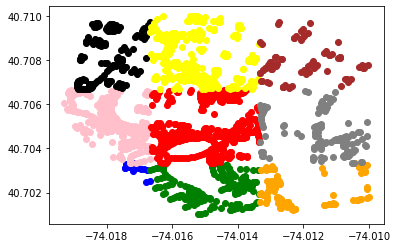

In [16]:
color_list = ["blue", "green", "orange", "pink", "red", "gray", "black", "yellow", "brown"]
count = 0
for i, area_id in enumerate(area_list):
    print(area_id)
    node_ids = area_node_dict[area_id]
    tmp_df = pd.DataFrame({"NodeID": node_ids})
    tmp_df_2 = pd.merge(tmp_df, node_info_df, on="NodeID")
    plt.scatter(tmp_df_2["Longitude"], tmp_df_2["Latitude"], color=color_list[i])
    

In [79]:
area_node_dict[0]

[3274304827,
 561042148,
 3274304829,
 561042126,
 1494150040,
 561042125,
 1494150079,
 1494150021,
 1494150098,
 6297396144,
 3579133728,
 3579133729,
 3579133730,
 5816038508]

14